In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
data=pd.read_csv(r"G:\datasets\creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
#split - scaled data
X=data.drop(columns='Class')
y=data['Class']

scale=StandardScaler()
X_scaled=pd.DataFrame(scale.fit_transform(X),columns=X.columns)

train_X,test_X,train_y,test_y=train_test_split(X_scaled,y,test_size=0.3,random_state=33)

print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)
print(y.value_counts())
# data_scaled=pd.concat([X_scaled,y],axis=1)
# plt.figure(figsize=(30,30))
# sns.heatmap(data_scaled.corr(), annot=True)


(199364, 30) (85443, 30) (199364,) (85443,)
Class
0    284315
1       492
Name: count, dtype: int64


In [17]:
# Step 1: Under-sampling
under_sampling = RandomUnderSampler()
train_X_under_sampled, train_y_under_sampled = under_sampling.fit_resample(train_X, train_y)

# Check the class distribution after under-sampling
scaled_balanced_data_under = pd.concat([train_X_under_sampled, train_y_under_sampled], axis=1)
print("Under-sampled class distribution:")
print(scaled_balanced_data_under['Class'].value_counts())

# Step 2: Over-sampling on the under-sampled data
over_sampling = RandomOverSampler()
train_X_over_sampled, train_y_over_sampled = over_sampling.fit_resample(train_X_under_sampled, train_y_under_sampled)

# Check the class distribution after over-sampling
scaled_balanced_data_over = pd.concat([train_X_over_sampled, train_y_over_sampled], axis=1)
print("Over-sampled class distribution on under-sampled data:")
print(scaled_balanced_data_over['Class'].value_counts())


Under-sampled class distribution:
Class
0    341
1    341
Name: count, dtype: int64
Over-sampled class distribution on under-sampled data:
Class
0    341
1    341
Name: count, dtype: int64


In [21]:
results_df = pd.DataFrame(columns=["Model", "Strategy", "Recall of Fraud", "F1 Score", "ROC Score","Accuracy","test_confusion"])
def model_result(train_X,test_X,train_y,test_y,model,model_name,strategy):
    print(f"train_X shape: {train_X.shape}")
    print(f"train_y shape: {train_y.shape}")
    print(f"test_X shape: {test_X.shape}")
    print(f"test_y shape: {test_y.shape}")

    model.fit(train_X,train_y)
    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)
    
     # Display best parameters and best score if model is a GridSearchCV object
    if hasattr(model, 'best_params_'):
        print(f"Best Parameters for {model_name}: {model.best_params_}")
        print(f"Best Cross-Validation Score: {model.best_score_}")

#     print("Train Accuracy : ",accuracy_score(train_y, train_pred))
#     print("Test Accuracy : ",accuracy_score(test_y, test_pred))
#     print("Train Report : \n",classification_report(train_y, train_pred))
#     print("Test Report : \n",classification_report(test_y, test_pred))
#     print("Train Confusion. Matrix : \n",confusion_matrix(train_y, train_pred))
#     print("Test Confusion. Matrix  : \n",confusion_matrix(test_y, test_pred))  
#     print("TRAIN ROC AUC SCORE  : \n",roc_auc_score(train_y, train_pred))
#     print("Test ROC AUC SCORE  : \n",roc_auc_score(test_y, test_pred))
    
    test_report=classification_report(test_y, test_pred,output_dict=True)
    recall_of_fraud=test_report["1"]["recall"]
    f1_score=test_report["1"]["f1-score"]
    roc=roc_auc_score(test_y, test_pred)
    acc=accuracy_score(test_y, test_pred)
    test_con=confusion_matrix(test_y,test_pred)
    global results_df
    new_row= pd.DataFrame({
        "Model":[model_name],
        "Strategy":[strategy],
        "Recall of Fraud":[recall_of_fraud],
        "F1 Score":[f1_score],
        "ROC Score":[roc],
        "Accuracy":[acc],          
        "test_confusion":[test_con]
    })
    results_df=pd.concat([results_df,new_row],ignore_index=True)
    results_df.to_csv("model_result.csv", index=False)
    
    y_pred_proba = model.predict_proba(test_X)[:, 1] 
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba) 
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()  
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Fraudulent Transaction Classification')
    plt.legend()
    plt.show()
    
    # Plot TPR, FPR against thresholds to find the optimal one
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tpr, label="True Positive Rate (Sensitivity)")
    plt.plot(thresholds, fpr, label="False Positive Rate (1 - Specificity)")
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title("TPR and FPR at Different Thresholds")
    plt.legend(loc="best")
    plt.show()
    
    # Optional: Calculate the optimal threshold based on Youden's J statistic
    j_scores = tpr - fpr
    optimal_idx = j_scores.argmax()
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold (Youden's J): {optimal_threshold}")

    
    #print(results_df)
    return results_df


train_X shape: (682, 30)
train_y shape: (682,)
test_X shape: (85443, 30)
test_y shape: (85443,)


C:\Users\Gayathri\AppData\Local\Temp\ipykernel_20996\444432378.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df=pd.concat([results_df,new_row],ignore_index=True)


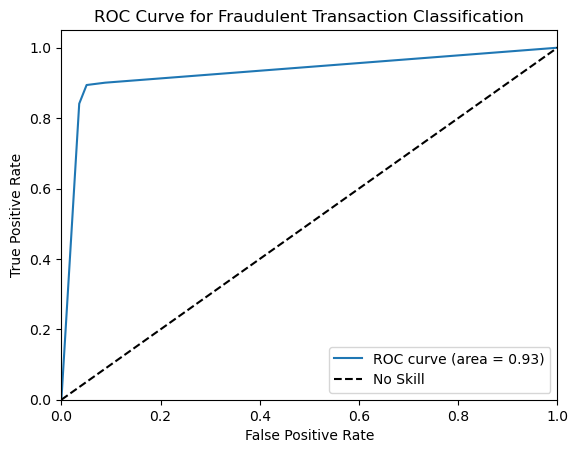

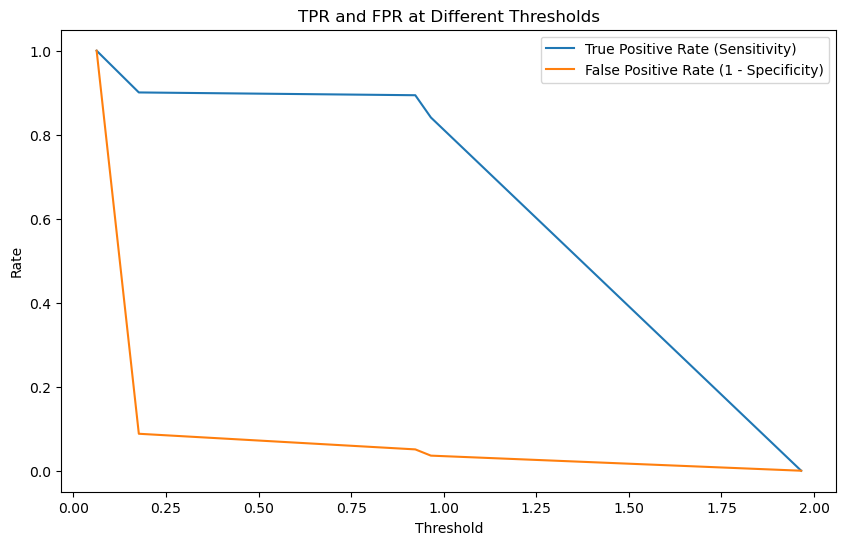

Optimal Threshold (Youden's J): 0.9230769230769231


In [22]:
model=DecisionTreeClassifier(criterion='gini', max_depth= 10, max_features= 'sqrt', max_leaf_nodes= 10, min_impurity_decrease= 0.01, min_samples_leaf= 1, min_samples_split= 2)
result=model_result(train_X_over_sampled,test_X, train_y_over_sampled,test_y,model,"decisiontree-tuned","scaled balanced data")

In [23]:
results_df

,Model,Strategy,Recall of Fraud,F1 Score,ROC Score,Accuracy,test_confusion
0,decisiontree-tuned,scaled balanced data,0.89404,0.058467,0.921625,0.949112,"[[80960, 4332], [16, 135]]"
